In [115]:
import matplotlib.pyplot as pl
%matplotlib inline
import numpy as np
import everest

In [145]:
# Download the data
# star = everest.Everest(210517342)
star = everest.Everest(211836369)

# Remove outliers, get a nice subset of the data
cut = slice(None)
t = star.apply_mask(star.time)[cut]
F = star.apply_mask(star.fpix)[cut]
fdet = star.apply_mask(star.flux)[cut]

INFO  [everest.user.DownloadFile()]: Downloading the file...
INFO  [everest.user.load_fits()]: Loading FITS file for 211836369.


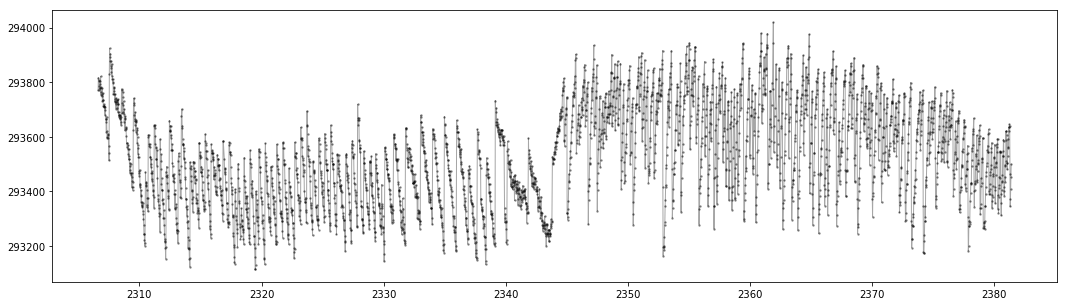

In [146]:
# Find the outliers
fsap = np.sum(F, axis = 1)
f = everest.math.SavGol(fsap)
M = np.nanmedian(f)
MAD = 1.4826 * np.nanmedian(np.abs(f - M))
out = (f > M + 5 * MAD) | (f < M - 5 * MAD)
fig = pl.figure(figsize = (18,5))
pl.plot(t[~out], fsap[~out], 'k.-', alpha = 0.35, ms = 3, lw = 1);
pl.plot(t[out], fsap[out], 'r.', alpha = 0.7, ms = 3, lw = 1);

In [147]:
# Apply the cut
t = np.array(t[~out])
fsap = np.array(fsap[~out])
F = np.array(F[~out,:])
fdet = np.array(fdet[~out])

In [148]:
# Normalize
med = np.median(fsap)
fsap /= med
F /= med
fdet /= med

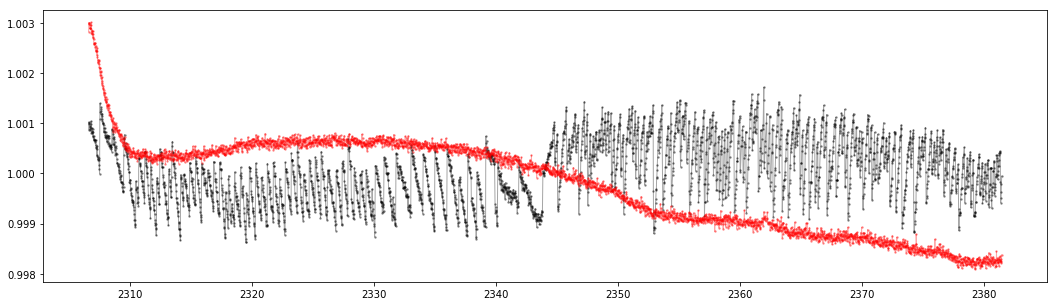

In [149]:
# Plot de-trended
fig = pl.figure(figsize = (18,5))
pl.plot(t, fsap, 'k.-', alpha = 0.35, ms = 3, lw = 1);
pl.plot(t, fdet, 'r.-', alpha = 0.35, ms = 3, lw = 1);

In [150]:
# Celerite on raw data
import celerite
from celerite import terms

In [225]:
yerr = np.nanmedian(np.abs(np.diff(fsap)))
kernel = terms.SHOTerm(log_S0 = np.log(np.var(fsap)), log_Q = -0.5 * np.log(2), 
                       log_omega0 = np.log(2 * np.pi / 8.),
                       bounds = dict(log_S0 = (-15,5), log_omega0 = np.log(2 * np.pi / np.array([15., 1.]))))
kernel.freeze_parameter('log_Q')
kernel += terms.JitterTerm(log_sigma = np.log(yerr))

In [226]:
gp = celerite.GP(kernel = kernel, mean = 1.)
gp.compute(t)

In [153]:
#mu = gp.predict(fsap, return_cov = False)

In [155]:
# Plot
#fig = pl.figure(figsize = (18,5))
#pl.plot(t, fsap, 'k.-', alpha = 0.35, ms = 3, lw = 1);
#pl.plot(t, mu, 'r.-', alpha = 0.35, ms = 3, lw = 1);

In [156]:
#def NegLnLike(x, **kwargs):
#    gp.set_parameter_vector(x)
#    return -gp.log_likelihood(fsap)

In [129]:
# NegLnLike(gp.get_parameter_vector())

1883.4179464703084

In [130]:
# gp.get_parameter_vector()

array([-13.23370204,  -0.24156448,  -8.98108956])

In [131]:
# from scipy.optimize import minimize
# x0 = gp.get_parameter_vector()
# bounds = gp.get_parameter_bounds()
# res = minimize(NegLnLike, x0, bounds = bounds)

In [132]:
# res

      fun: -22178.27923629494
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  8.00355338e-03,  -2.16210901e+02,  -4.36557457e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 92
      nit: 20
   status: 0
  success: True
        x: array([-13.75311567,   1.83787707,  -8.23117053])

In [133]:
# gp.set_parameter_vector(res.x)
# gp.get_parameter_vector()

array([-13.75311567,   1.83787707,  -8.23117053])

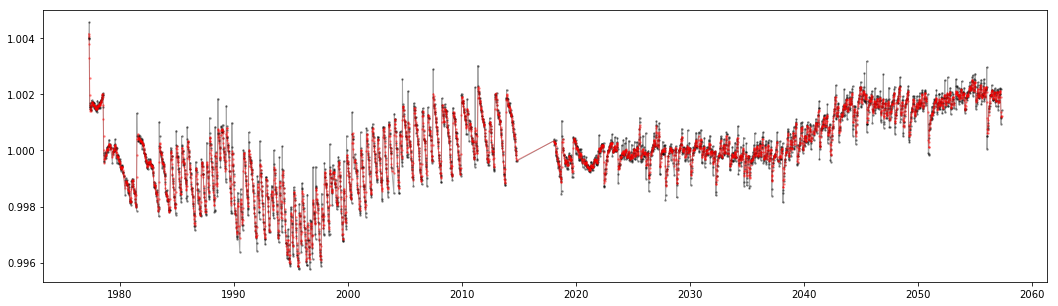

In [134]:
# Plot
# mu = gp.predict(fsap, return_cov = False)
# fig = pl.figure(figsize = (18,5))
# pl.plot(t, fsap, 'k.-', alpha = 0.35, ms = 3, lw = 1);
# pl.plot(t, mu, 'r.-', alpha = 0.35, ms = 3, lw = 1);

In [227]:
# Get 1st order design matrix w/ regularization
lam = 10.
A = F / fsap.reshape(-1, 1)
L = lam * np.ones(F.shape[1])

In [228]:
# Compute a sample model
from scipy.linalg import cho_factor, cho_solve
alpha = np.dot(A.T, gp.apply_inverse(fsap - 1.)[:, 0])
ATKinvA = np.dot(A.T, gp.apply_inverse(A))
S = np.array(ATKinvA)
S[np.diag_indices_from(S)] += 1. / L
factor = cho_factor(S, overwrite_a=True)
alpha -= np.dot(ATKinvA, cho_solve(factor, alpha))
pred = np.dot(A, L * alpha)
print(gp.log_likelihood(fsap - pred))

28181.946436876016


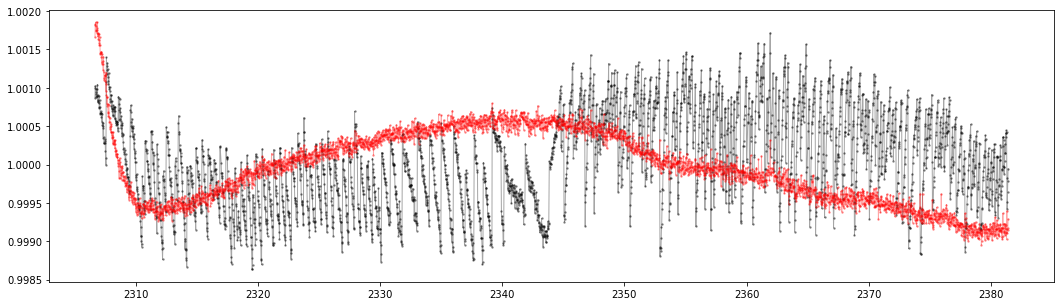

In [229]:
fig = pl.figure(figsize = (18,5))
pl.plot(t, fsap, 'k.-', alpha = 0.35, ms = 3, lw = 1);
pl.plot(t, fsap - pred, 'r.-', alpha = 0.35, ms = 3, lw = 1);

In [230]:
def get_pred():
    alpha = np.dot(A.T, gp.apply_inverse(fsap - 1.)[:, 0])
    ATKinvA = np.dot(A.T, gp.apply_inverse(A))
    S = np.array(ATKinvA)
    S[np.diag_indices_from(S)] += 1. / L
    factor = cho_factor(S, overwrite_a=True)
    alpha -= np.dot(ATKinvA, cho_solve(factor, alpha))
    return np.dot(A, L * alpha)

def NegLnLike(x, **kwargs):
    gp.set_parameter_vector(x)
    pred = get_pred()
    return -gp.log_likelihood(fsap - pred)

In [161]:
%timeit NegLnLike(gp.get_parameter_vector())

100 loops, best of 3: 4.63 ms per loop


In [231]:
x0 = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
res = minimize(NegLnLike, x0, bounds = bounds)
gp.set_parameter_vector(res.x)

In [163]:
res

      fun: -28406.959969973166
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.26500561,  26.87229426,   9.45437932])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 84
      nit: 12
   status: 0
  success: True
        x: array([-14.09505837,  -0.87017313,  -9.58842447])

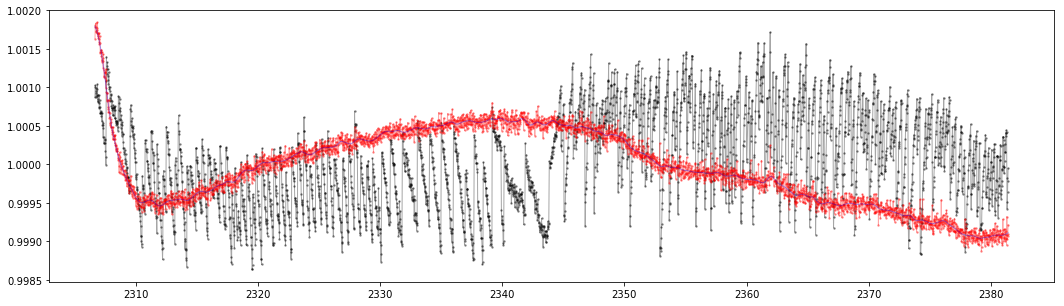

In [232]:
fig = pl.figure(figsize = (18,5))
pl.plot(t, fsap, 'k.-', alpha = 0.35, ms = 3, lw = 1);
pl.plot(t, fsap - get_pred(), 'r.-', alpha = 0.35, ms = 3, lw = 1);
pl.plot(t, gp.predict(fsap - get_pred(), return_cov = False), 'b-', alpha = 0.35, ms = 3, lw = 1);

In [233]:
star.dvs()

INFO  [everest.user.DownloadFile()]: Found cached file.
